Random sample starting from index 121958 (2022-11-24 09:45:00)


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


Intelligent Chop columns added:
['IC_Regime', 'IC_RegimeName', 'IC_Confidence', 'IC_ADX', 'IC_ChoppinessIndex', 'IC_BandWidth', 'IC_ATR_Normalized', 'IC_EfficiencyRatio', 'IC_DI_Plus', 'IC_DI_Minus', 'IC_BB_Upper', 'IC_BB_Middle', 'IC_BB_Lower', 'IC_Signal', 'IC_RiskLevel']


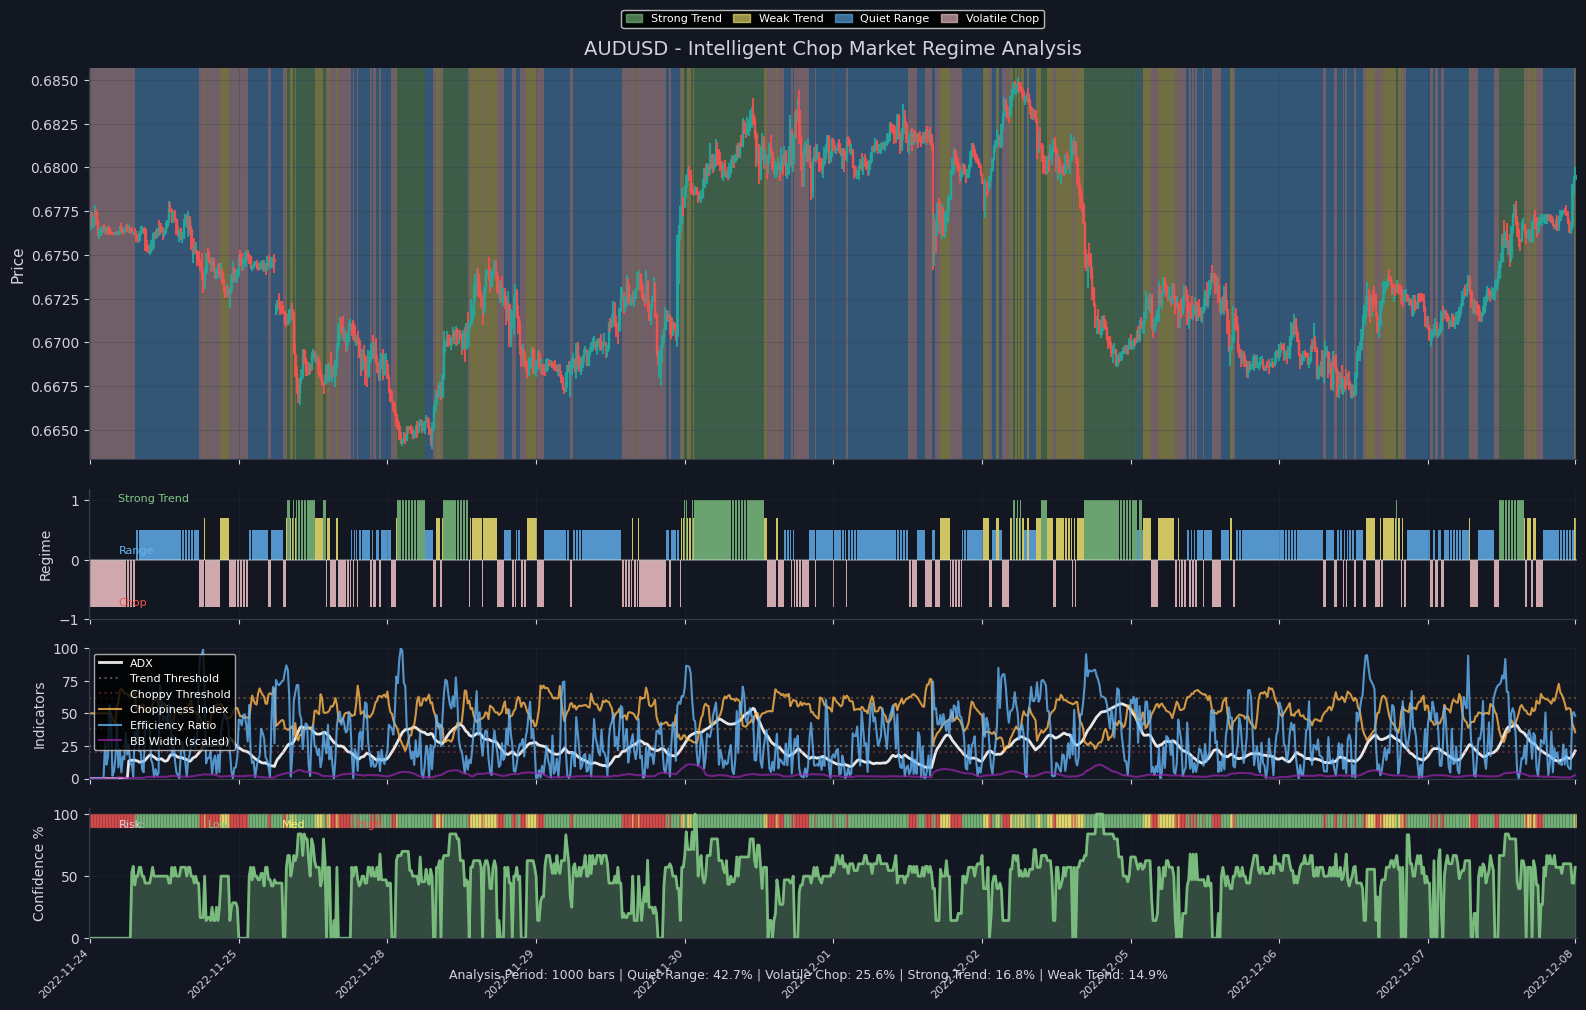

,Open,High,Low,Close,IC_Regime,IC_RegimeName,IC_Confidence,IC_ADX,IC_ChoppinessIndex,IC_BandWidth,IC_ATR_Normalized,IC_EfficiencyRatio,IC_DI_Plus,IC_DI_Minus,IC_BB_Upper,IC_BB_Middle,IC_BB_Lower,IC_Signal,IC_RiskLevel
DateTime,,,,,,,,,,,,,,,,,,,
2022-11-24 09:45:00,0.67646,0.67751,0.67641,0.67729,0,Volatile Chop,0.000000,0.000000,50.000000,0.000000,0.162412,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1,High
2022-11-24 10:00:00,0.67729,0.67737,0.67665,0.67667,0,Volatile Chop,0.000000,0.000000,50.000000,0.000000,0.134482,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1,High
2022-11-24 10:15:00,0.67665,0.67711,0.67657,0.67694,0,Volatile Chop,0.000000,0.000000,50.000000,0.000000,0.116209,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1,High
2022-11-24 10:30:00,0.67697,0.67777,0.67692,0.67752,0,Volatile Chop,0.000000,0.000000,50.000000,0.000000,0.118447,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1,High
2022-11-24 10:45:00,0.67752,0.67755,0.67679,0.67692,0,Volatile Chop,0.000000,0.000000,50.000000,0.000000,0.117296,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1,High
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-08 19:30:00,0.67688,0.67697,0.67632,0.67644,3,Quiet Range,60.000000,15.523331,53.964685,0.174997,0.071465,0.076233,18.579375,22.627304,0.677664,0.677071,0.676479,0,Low
2022-12-08 19:45:00,0.67644,0.67669,0.67624,0.67667,3,Quiet Range,60.000000,15.291798,52.949937,0.182481,0.070782,0.071429,17.446063,22.331490,0.677669,0.677051,0.676434,0,Low
2022-12-08 20:00:00,0.67667,0.67898,0.67650,0.67896,3,Quiet Range,44.444444,16.984572,42.719468,0.306173,0.109840,0.489933,37.352587,16.395763,0.678182,0.677145,0.676109,0,Low


In [1]:
import pandas as pd
from technical_indicators_custom import TIC
from technical_indicators_custom.plotting import IndicatorPlotter
import numpy as np


# Load your OHLC data
df = pd.read_csv('../data/AUDUSD_MASTER_15M.csv')

# Convert DateTime column to datetime and set as index
df['DateTime'] = pd.to_datetime(df['DateTime'])
df.set_index('DateTime', inplace=True)

# Random contiguous sample - select a random starting point and take 1000 consecutive rows
np.random.seed(42)  # Remove this line for different sample each time
max_start = len(df) - 1000
random_start = np.random.randint(0, max_start)
df_analysis = df.iloc[random_start:random_start + 1000].copy()

print(f"Random sample starting from index {random_start} ({df.index[random_start]})")


# Add indicators
df_analysis = TIC.add_intelligent_chop(df_analysis)

# Display new columns
print("Intelligent Chop columns added:")
ic_cols = [col for col in df_analysis.columns if col.startswith('IC_')]
print(ic_cols)



# Plot using the dedicated plotting function
from technical_indicators_custom.plotting import plot_intelligent_chop_indicator
plot_intelligent_chop_indicator(
    df_analysis,
    title="AUDUSD - Intelligent Chop Market Regime Analysis",
    figsize=(16, 10),show=True
)
df_analysis

## Neuro Trend

In [2]:
df_analysis

,Open,High,Low,Close,IC_Regime,IC_RegimeName,IC_Confidence,IC_ADX,IC_ChoppinessIndex,IC_BandWidth,IC_ATR_Normalized,IC_EfficiencyRatio,IC_DI_Plus,IC_DI_Minus,IC_BB_Upper,IC_BB_Middle,IC_BB_Lower,IC_Signal,IC_RiskLevel
DateTime,,,,,,,,,,,,,,,,,,,
2022-11-24 09:45:00,0.67646,0.67751,0.67641,0.67729,0,Volatile Chop,0.000000,0.000000,50.000000,0.000000,0.162412,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1,High
2022-11-24 10:00:00,0.67729,0.67737,0.67665,0.67667,0,Volatile Chop,0.000000,0.000000,50.000000,0.000000,0.134482,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1,High
2022-11-24 10:15:00,0.67665,0.67711,0.67657,0.67694,0,Volatile Chop,0.000000,0.000000,50.000000,0.000000,0.116209,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1,High
2022-11-24 10:30:00,0.67697,0.67777,0.67692,0.67752,0,Volatile Chop,0.000000,0.000000,50.000000,0.000000,0.118447,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1,High
2022-11-24 10:45:00,0.67752,0.67755,0.67679,0.67692,0,Volatile Chop,0.000000,0.000000,50.000000,0.000000,0.117296,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1,High
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-08 19:30:00,0.67688,0.67697,0.67632,0.67644,3,Quiet Range,60.000000,15.523331,53.964685,0.174997,0.071465,0.076233,18.579375,22.627304,0.677664,0.677071,0.676479,0,Low
2022-12-08 19:45:00,0.67644,0.67669,0.67624,0.67667,3,Quiet Range,60.000000,15.291798,52.949937,0.182481,0.070782,0.071429,17.446063,22.331490,0.677669,0.677051,0.676434,0,Low
2022-12-08 20:00:00,0.67667,0.67898,0.67650,0.67896,3,Quiet Range,44.444444,16.984572,42.719468,0.306173,0.109840,0.489933,37.352587,16.395763,0.678182,0.677145,0.676109,0,Low


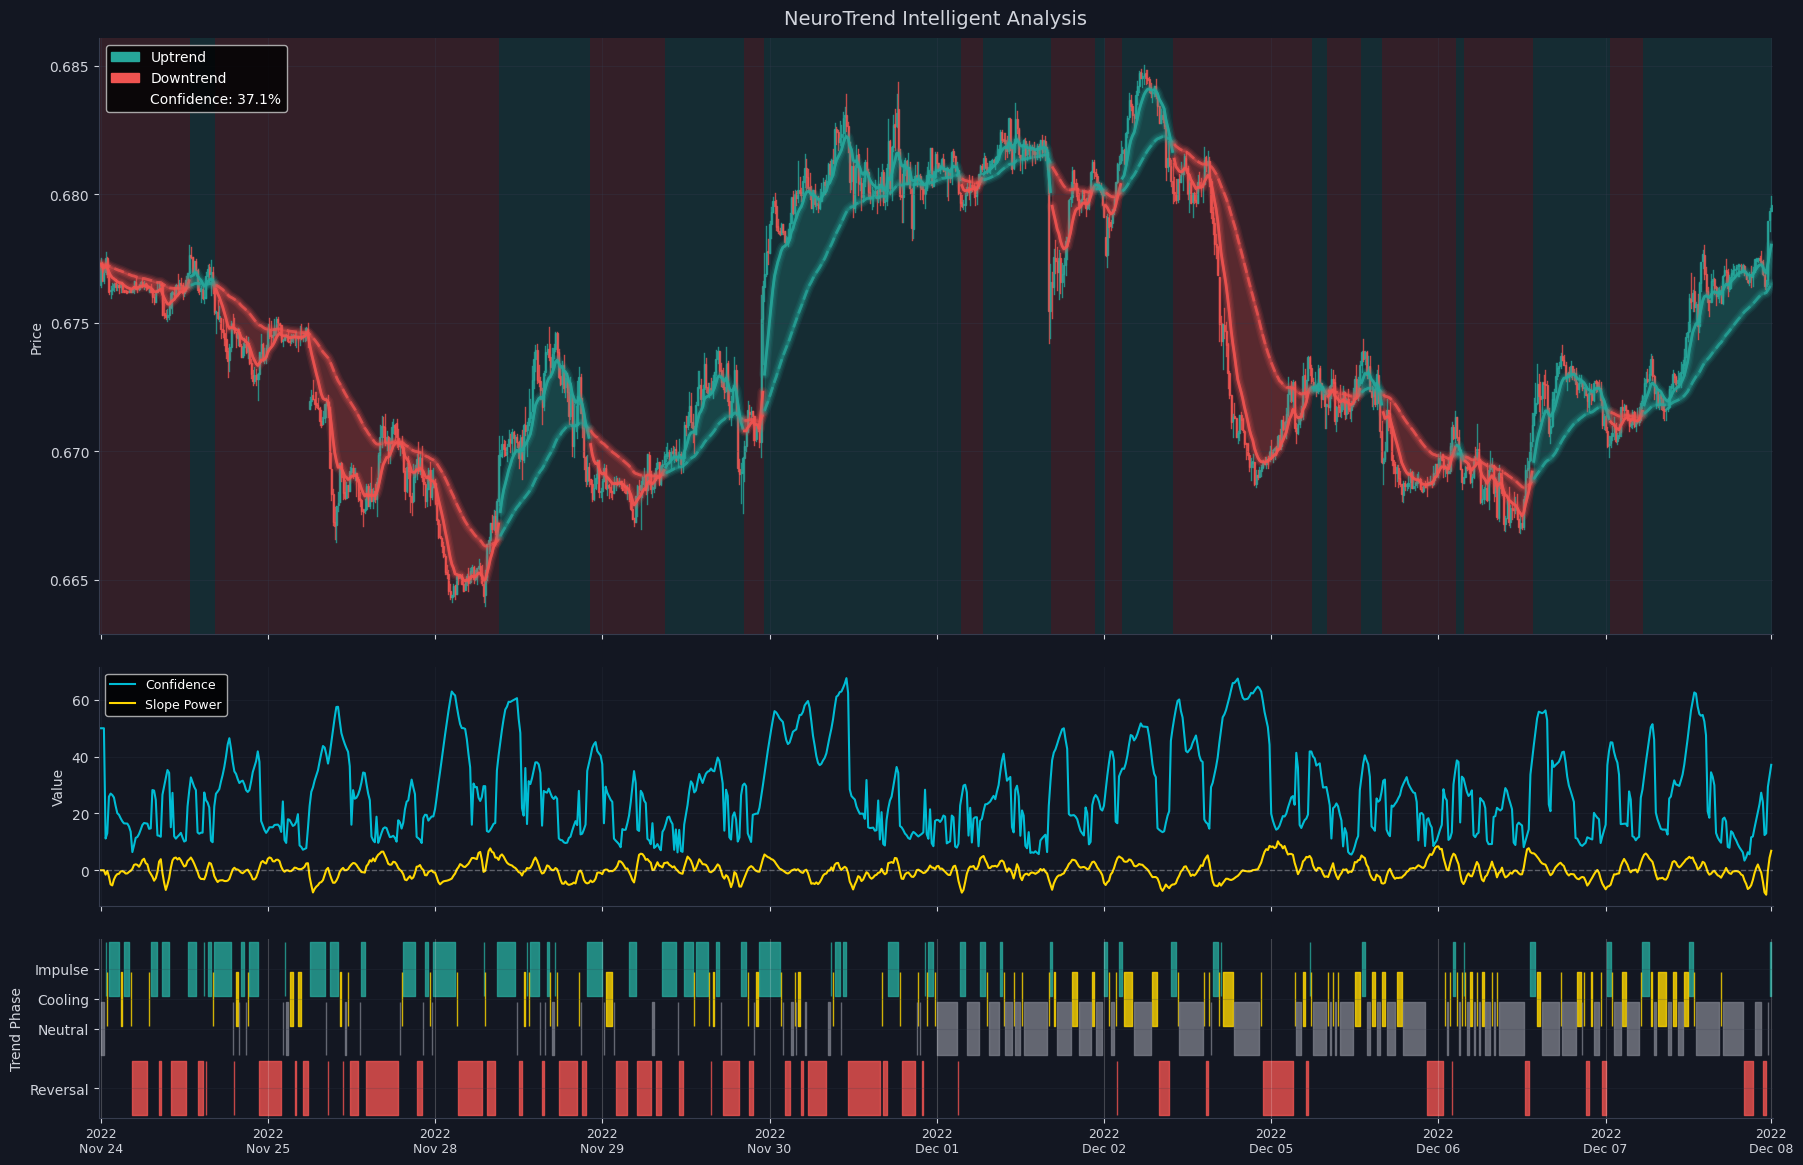

,Open,High,Low,Close,IC_Regime,IC_RegimeName,IC_Confidence,IC_ADX,IC_ChoppinessIndex,IC_BandWidth,...,NTI_FastEMA,NTI_SlowEMA,NTI_SlopePower,NTI_TrendPhase,NTI_DirectionRaw,NTI_Direction,NTI_Confidence,NTI_ReversalRisk,NTI_StallDetected,NTI_SlopeForecast
DateTime,,,,,,,,,,,,,,,,,,,,,
2022-11-24 09:45:00,0.67646,0.67751,0.67641,0.67729,0,Volatile Chop,0.000000,0.000000,50.000000,0.000000,...,0.677290,0.677290,0.000000,Neutral,-1,-1.0,50.000000,False,False,0.000000
2022-11-24 10:00:00,0.67729,0.67737,0.67665,0.67667,0,Volatile Chop,0.000000,0.000000,50.000000,0.000000,...,0.677177,0.677270,0.000000,Neutral,-1,-1.0,50.000000,False,False,0.000000
2022-11-24 10:15:00,0.67665,0.67711,0.67657,0.67694,0,Volatile Chop,0.000000,0.000000,50.000000,0.000000,...,0.677134,0.677257,0.000000,Neutral,-1,-1.0,50.000000,False,False,0.000000
2022-11-24 10:30:00,0.67697,0.67777,0.67692,0.67752,0,Volatile Chop,0.000000,0.000000,50.000000,0.000000,...,0.677204,0.677267,-1.546057,Impulse,-1,-1.0,11.176925,False,False,-1.546057
2022-11-24 10:45:00,0.67752,0.67755,0.67679,0.67692,0,Volatile Chop,0.000000,0.000000,50.000000,0.000000,...,0.677153,0.677254,-0.220796,Cooling,-1,-1.0,13.027583,False,False,-0.220796
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-08 19:30:00,0.67688,0.67697,0.67632,0.67644,3,Quiet Range,60.000000,15.523331,53.964685,0.174997,...,0.677020,0.676154,-7.803768,Reversal,1,1.0,12.397650,True,False,-16.093262
2022-12-08 19:45:00,0.67644,0.67669,0.67624,0.67667,3,Quiet Range,60.000000,15.291798,52.949937,0.182481,...,0.676942,0.676180,-8.615453,Reversal,1,1.0,13.008375,True,False,-16.435111
2022-12-08 20:00:00,0.67667,0.67898,0.67650,0.67896,3,Quiet Range,44.444444,16.984572,42.719468,0.306173,...,0.677309,0.676279,-0.185158,Neutral,1,1.0,29.341010,True,False,3.577695


In [3]:

# This code will now produce the new, professional multi-panel chart
df_analysis = TIC.add_neuro_trend_intelligent(
    df_analysis,  
    base_fast=10,
    base_slow=50,
    confirm_bars=3
)

TIC.plot(df_analysis, title="NeuroTrend Intelligent Analysis",show=True)
df_analysis

Market Bias columns added:
['IC_Regime', 'IC_RegimeName', 'IC_Confidence', 'IC_ADX', 'IC_ChoppinessIndex', 'IC_BandWidth', 'IC_ATR_Normalized', 'IC_EfficiencyRatio', 'IC_DI_Plus', 'IC_DI_Minus', 'IC_BB_Upper', 'IC_BB_Middle', 'IC_BB_Lower', 'IC_Signal', 'IC_RiskLevel', 'NTI_FastEMA', 'NTI_SlowEMA', 'NTI_SlopePower', 'NTI_TrendPhase', 'NTI_DirectionRaw', 'NTI_Direction', 'NTI_Confidence', 'NTI_ReversalRisk', 'NTI_StallDetected', 'NTI_SlopeForecast', 'MB_h2', 'MB_l2', 'MB_ha_avg', 'MB_Bias', 'MB_o2', 'MB_c2']


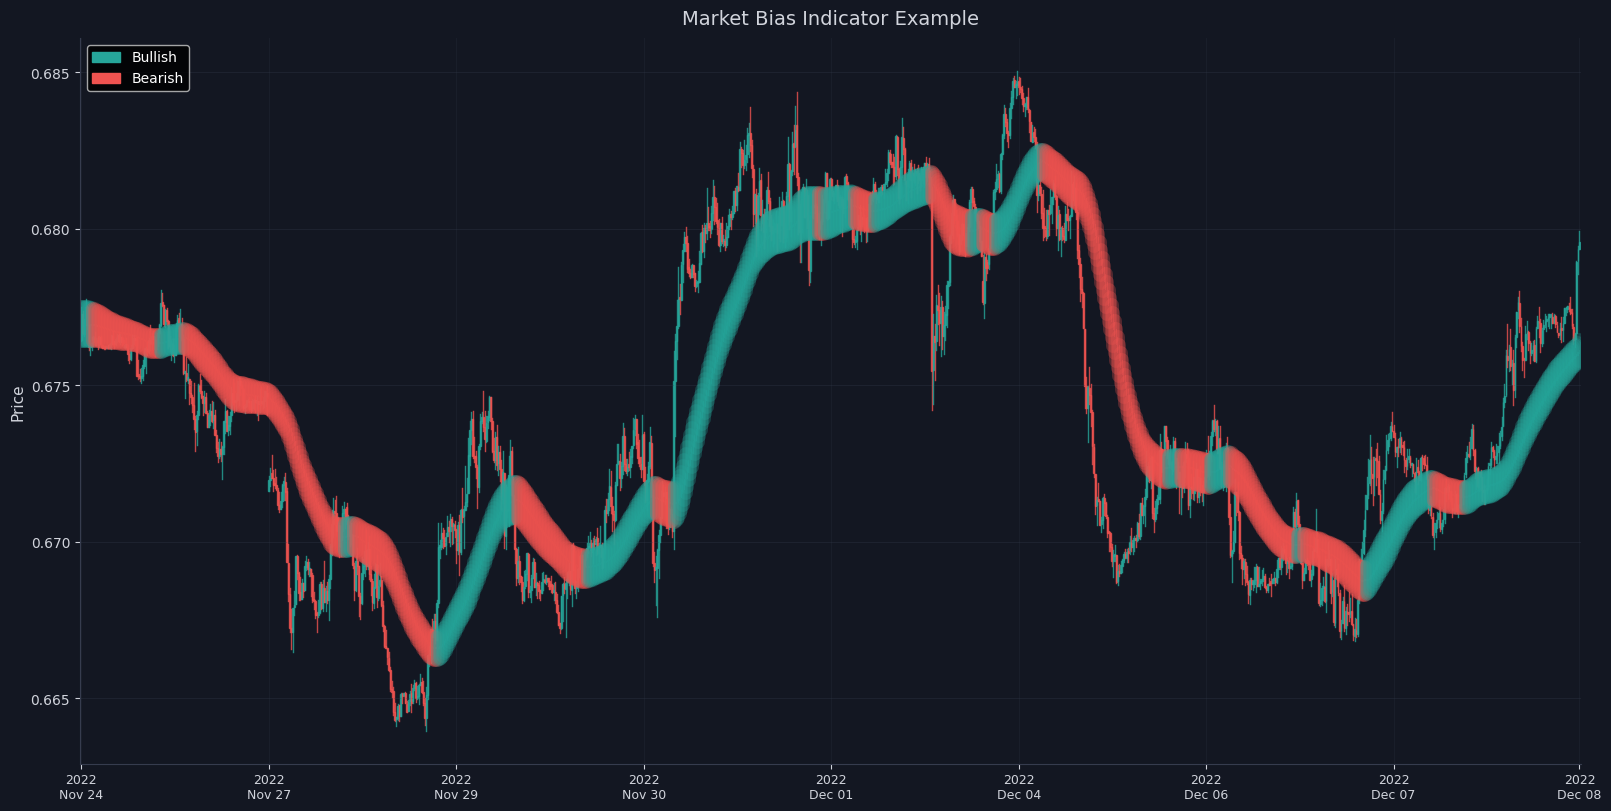

,Open,High,Low,Close,IC_Regime,IC_RegimeName,IC_Confidence,IC_ADX,IC_ChoppinessIndex,IC_BandWidth,...,NTI_Confidence,NTI_ReversalRisk,NTI_StallDetected,NTI_SlopeForecast,MB_h2,MB_l2,MB_ha_avg,MB_Bias,MB_o2,MB_c2
DateTime,,,,,,,,,,,,,,,,,,,,,
2022-11-24 09:45:00,0.67646,0.67751,0.67641,0.67729,0,Volatile Chop,0.000000,0.000000,50.000000,0.000000,...,50.000000,False,False,0.000000,0.677510,0.676410,0.676960,1,0.676875,0.676918
2022-11-24 10:00:00,0.67729,0.67737,0.67665,0.67667,0,Volatile Chop,0.000000,0.000000,50.000000,0.000000,...,50.000000,False,False,0.000000,0.677509,0.676412,0.676960,1,0.676879,0.676918
2022-11-24 10:15:00,0.67665,0.67711,0.67657,0.67694,0,Volatile Chop,0.000000,0.000000,50.000000,0.000000,...,50.000000,False,False,0.000000,0.677505,0.676414,0.676960,1,0.676884,0.676918
2022-11-24 10:30:00,0.67697,0.67777,0.67692,0.67752,0,Volatile Chop,0.000000,0.000000,50.000000,0.000000,...,11.176925,False,False,-1.546057,0.677504,0.676420,0.676962,1,0.676889,0.676920
2022-11-24 10:45:00,0.67752,0.67755,0.67679,0.67692,0,Volatile Chop,0.000000,0.000000,50.000000,0.000000,...,13.027583,False,False,-0.220796,0.677504,0.676427,0.676965,1,0.676895,0.676924
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-08 19:30:00,0.67688,0.67697,0.67632,0.67644,3,Quiet Range,60.000000,15.523331,53.964685,0.174997,...,12.397650,True,False,-16.093262,0.676215,0.675582,0.675898,1,0.675800,0.675905
2022-12-08 19:45:00,0.67644,0.67669,0.67624,0.67667,3,Quiet Range,60.000000,15.291798,52.949937,0.182481,...,13.008375,True,False,-16.435111,0.676255,0.675628,0.675941,1,0.675852,0.675948
2022-12-08 20:00:00,0.67667,0.67898,0.67650,0.67896,3,Quiet Range,44.444444,16.984572,42.719468,0.306173,...,29.341010,True,False,3.577695,0.676306,0.675670,0.675988,1,0.675900,0.675995


In [4]:
# Add Market Bias indicator
df_analysis = TIC.add_market_bias(df_analysis, ha_len=50, ha_len2=10)

# Display the new columns added
print("Market Bias columns added:")
market_bias_cols = [col for col in df_analysis.columns if col not in df.columns]
print(market_bias_cols)
# Create the plot
plotter = IndicatorPlotter()
# Create the plot
fig = plotter.plot(
    df_analysis,
    show_supertrend=False,
    show_market_bias=True,
    show_fractal_sr=False,
    show_neurotrend=False,
    title="Market Bias Indicator Example",
    figsize=(16, 8)
)

df_analysis

Random sample starting from index 146867 (2024-01-11 17:00:00)
Calculating NeuroTrend Intelligent...
Calculating Market Bias...
Calculating Intelligent Chop...
Creating combined plot...
Chart saved to charts/plot_panoramic.png


<Figure size 2000x1600 with 0 Axes>

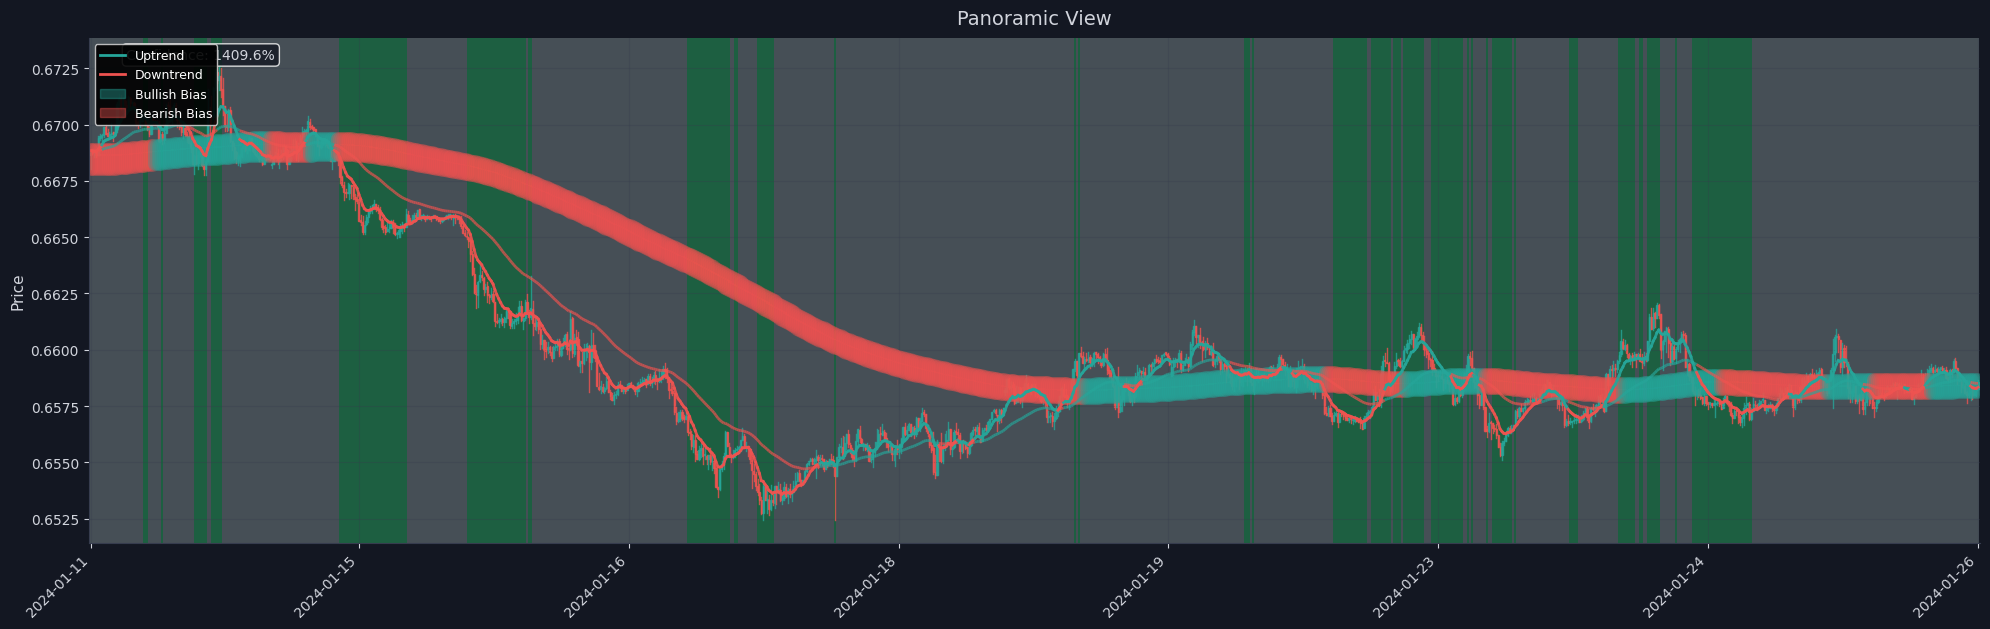

In [5]:
import pandas as pd


from technical_indicators_custom import TIC
from technical_indicators_custom.plotting import IndicatorPlotter
import numpy as np
from technical_indicators_custom.plotting import plot_neurotrend_market_bias_chop



# Initialize the plotter
plotter = IndicatorPlotter()

# Load your OHLC data
df = pd.read_csv('../data/AUDUSD_MASTER_15M.csv')

# Convert DateTime column to datetime and set as index
df['DateTime'] = pd.to_datetime(df['DateTime'])
df.set_index('DateTime', inplace=True)

# Random contiguous sample - select a random starting point and take 1000 consecutive rows
# np.random.seed(42)  # Remove this line for different sample each time
max_start = len(df) - 1000
random_start = np.random.randint(0, max_start)
df_analysis = df.iloc[random_start:random_start + 1000].copy()

print(f"Random sample starting from index {random_start} ({df.index[random_start]})")


# Calculate indicators
print("Calculating NeuroTrend Intelligent...")
df_analysis = TIC.add_neuro_trend_intelligent(
    df_analysis,  
    base_fast=10,
    base_slow=50,
    confirm_bars=3
)   

print("Calculating Market Bias...")
df_analysis = df_analysis = TIC.add_market_bias(df_analysis, ha_len=300, ha_len2=30)  

print("Calculating Intelligent Chop...")
df_analysis = TIC.add_intelligent_chop(df_analysis)
 



# Create the combined plot
print("Creating combined plot...")
# fig = plot_neurotrend_market_bias_chop(
#     df_analysis,
#     title="Panoramic View",
#     figsize=(20, 16),  # Base size
#     save_path='charts/plot_panoramic.png',
#     show=True,
#     show_chop_subplots=False,
#     use_chop_background=True,
#     single_plot_height_ratio=0.4  # Results in 20x3.2
# )


fig = plot_neurotrend_market_bias_chop(
    df_analysis,
    title="Panoramic View",
    figsize=(20, 16),  # Base size
    save_path='charts/plot_panoramic.png',
    show=True,
    show_chop_subplots=False,
    use_chop_background=True,
    single_plot_height_ratio=0.4,  # Results in 20x3.2
    simplified_regime_colors=True,
    trend_color='#2ECC71',  # Hex color
    range_color='#95A5A6'   # Hex color
)





In [7]:
with pd.option_context('display.max_columns', None):
    print(df_analysis.tail())

                        Open     High      Low    Close  NTI_FastEMA  \
DateTime                                                               
2024-01-26 02:45:00  0.65807  0.65824  0.65777  0.65819     0.658391   
2024-01-26 03:00:00  0.65823  0.65841  0.65781  0.65800     0.658320   
2024-01-26 03:15:00  0.65801  0.65832  0.65798  0.65818     0.658294   
2024-01-26 03:30:00  0.65820  0.65841  0.65795  0.65826     0.658288   
2024-01-26 03:45:00  0.65827  0.65867  0.65824  0.65856     0.658338   

                     NTI_SlowEMA  NTI_SlopePower NTI_TrendPhase  \
DateTime                                                          
2024-01-26 02:45:00     0.658554       -3.115970        Cooling   
2024-01-26 03:00:00     0.658533       -2.383315        Neutral   
2024-01-26 03:15:00     0.658520       -1.546024        Neutral   
2024-01-26 03:30:00     0.658510       -0.974286        Neutral   
2024-01-26 03:45:00     0.658511        0.659803        Neutral   

                     NTI_